<h1><center> Dynamic Sparse CT </center></h1>

In this demo, we focus on different reconstruction methods for sparse dynamic CT using an open-access dynamic dataset available from [Heikkilä_et_al_Zenodo](https://zenodo.org/record/3696817#.YKTRP5MzZp9). The aim is to demonstrate how to increase
the temporal resolution, or to reduce the radiation dose of a CT scan, without sacrificing
the quality of the reconstructions.

The gel phantom simulates diffusion of liquids inside plant stems, namely the flow of iodine-based contrast agents used in high resolution tomographic X-ray imaging of plants. In order to test different reconstruction methods, this radiation resistant phantom with similar diffusion properties was constructed. For more information, please see [Heikkilä_et_al](https://arxiv.org/abs/2003.02841).


<h2><center><u> Learning objectives </u></center></h2>   

- Create an acquisition geometry for 2D dynamic tomographic data.
- Create **sparse data** using the `Slicer` processor.
- Run FBP reconstruction for every time-channel.
- Setup PDHG for 2 different regularisers: Total Variation and **Directional Total Variation**.

We first import all the necessary libraries for this notebook.

In [1]:
# Import libraries

from cil.framework import AcquisitionGeometry

from cil.optimisation.algorithms import PDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import IndicatorBox, BlockFunction, L2NormSquared, MixedL21Norm

from cil.io import NEXUSDataWriter, NEXUSDataReader

from cil.processors import Slicer

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins.ccpi_regularisation.functions import FGP_dTV, FGP_TV

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

from utilities_dynamic_ct import read_frames, read_extra_frames

from IPython.display import clear_output

import numpy as np

import os

# Data information: Gel phantom

The sample is an agarose-gel phantom, perfused with a liquid contrast agent in a 50ml Falcon test tube (ø 29 × 115mm) The aim of this experiment was to simulate diffusion of liquids inside plant stems, which cannot withstand high radiation doses from a denser set of measurement angles. After the agarose solidified, five intact plastic straws were made into the gel and filled with 20% sucrose solution to guarantee the diffusion by directing osmosis to the gel body.

Every measurement consists of 360 projections with 282 detectors bins obtained from a flat-panel circular-scan cone-beam microCT-scanner. Only the central slice is provided, resulting in a 2D __fanbeam geometry__. The primary measurements consisted of 17 consecutive time frames, with initial stage of no contrast agent followed by steady increase and diffusion into the gel body over time. Data is given in two different resolutions corresponding to reconstructions of size:

* 256 x 256: **GelPhantomData_b4.mat**
* 512 x 512: **GelPhantomData_b2.mat**

For this notebook, a 256x256 resolution is selected. In addition to the primary measurements, a more densely sampled measurements from the first time step and an additional 18th time step are provided in **GelPhantom_extra_frames.mat**

* Pre-scan: **720 projections**
* Post-scan: **1600 projections**

## Load and read dynamic data (mat files)

In [2]:
path = os.path.abspath("/mnt/materials/SIRF/Fully3D/CIL/GelPhantom")
data_mat = "GelPhantomData_b4"
file_info = read_frames(path, data_mat)

From the `file_info` variable, we have all the information in order to define our acquisition geometry and create our CIL acquisition data.

**Note that the pixel size of the detector is wrong. The correct pixel size should be doubled.**

In [3]:
# Get sinograms + metadata
sinograms = file_info['sinograms']
frames = sinograms.shape[0]
angles = file_info['angles']
distanceOriginDetector = file_info['distanceOriginDetector']
distanceSourceOrigin = file_info['distanceSourceOrigin']
# Correct the pixel size
pixelSize = 2*file_info['pixelSize']
numDetectors = file_info['numDetectors']

## Exercise 1: Create acquisition and image geometries

For this dataset, we have a 2D cone geometry with 17 time channels. Using the metadata above, we can define the acquisition geometry `ag` with 


```python    
    
    ag = AcquisitionGeometry.create_Cone2D(source_position = [0, distanceSourceOrigin],
                                           detector_position = [0, -distanceOriginDetector])\
                                        .set_panel(numDetectors, pixelSize)\
                                        .set_channels(frames)\
                                        .set_angles(angles, angle_unit="radian")\
                                        .set_labels(['channel','angle', 'horizontal'])

    
```

For the image geometry `ig` we use the following code and crop our image domain to `[256,256]`:

```python    
    
    ig = ag.get_ImageGeometry()
    
```



In [4]:
# Create acquisition + image geometries
ag = AcquisitionGeometry.create_Cone2D(source_position = ...,
                                       detector_position = ...)\
                                    .set_panel(numDetectors, ...)\
                                    .set_channels(...)\
                                    .set_angles(angles, angle_unit="radian")\
                                    .set_labels(['channel','angle', 'horizontal'])

ig = ag.get_ImageGeometry()
ig.voxel_num_x = 256
ig.voxel_num_y = 256

## Exercise 1: Solution

In [4]:
# Create acquisition + image geometries
ag = AcquisitionGeometry.create_Cone2D(source_position = [0, distanceSourceOrigin],
                                       detector_position = [0, -distanceOriginDetector])\
                                    .set_panel(numDetectors, pixelSize)\
                                    .set_channels(frames)\
                                    .set_angles(angles, angle_unit="radian")\
                                    .set_labels(['channel','angle', 'horizontal'])

ig = ag.get_ImageGeometry()
ig.voxel_num_x = 256
ig.voxel_num_y = 256

Then, we create an `AcquisitionData` by allocating space from the acquisition geometry `ag`. This is filled with every **sinogram per time channel**.

In [5]:
data = ag.allocate()
for i in range(frames):
   data.fill(sinograms[i], channel = i) 

## Show acquisition data

In [6]:
islicer(data, direction=0, cmap="inferno", title="Time frame")

interactive(children=(IntSlider(value=8, continuous_update=False, description='channel', max=16), FloatRangeSl…

IntSlider(value=8, continuous_update=False, description='channel', max=16)

## Show acquisition geometry

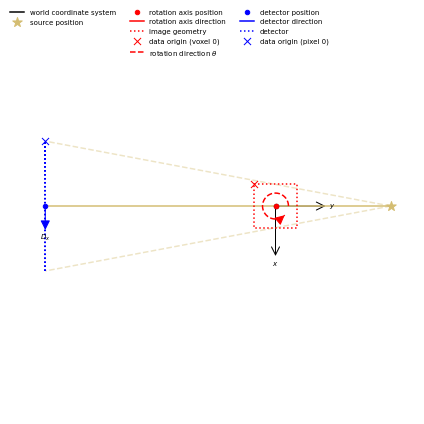

In [7]:
show_geometry(ag)

## Sparse CT data

In order to simulate a sparse acquisition, from the total of 360 projections we select a number of projections depending on the size of the `step`:

- step = 1 --> 360/1 projections
- step = 5 --> 360/5 = 72 projections
- step = 10 --> 360/10 = 36 projections
- step = 20 --> 360/20 = 18 projections

We create the sparse data using the `Slicer` processor. For every case, we show the dynamic data for 4 different time frames and save them using the `NEXUSDataWriter` processor in the `SparseData` directory.

/opt/SIRF-SuperBuild/INSTALL/python/cil/utilities/display.py:309: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


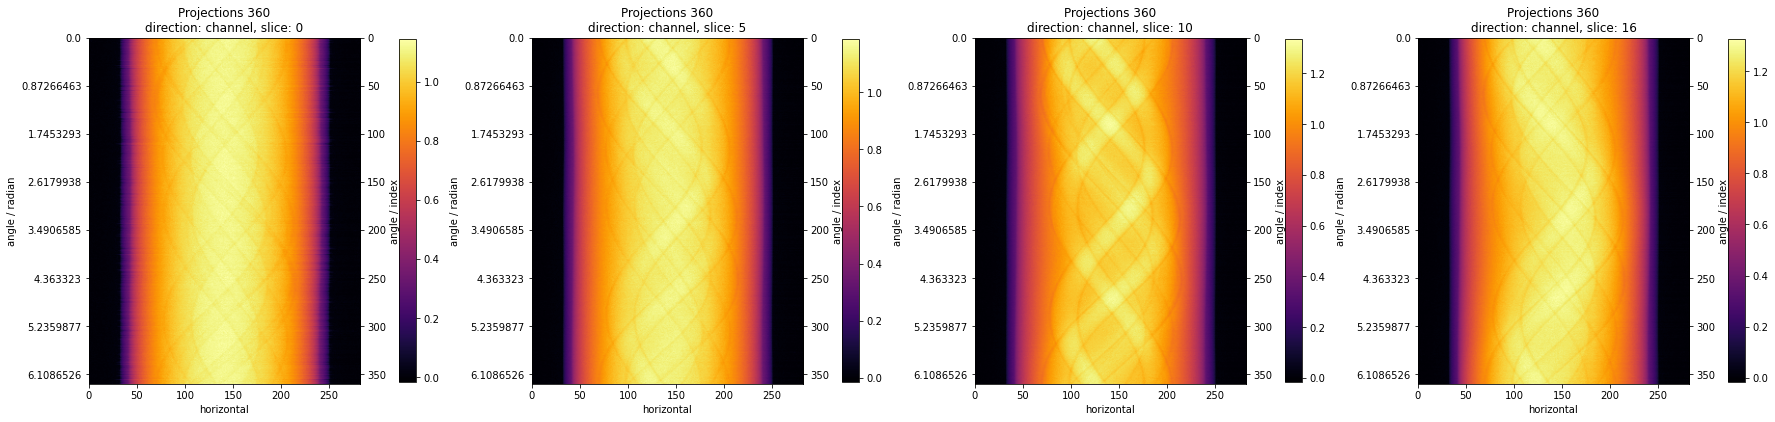

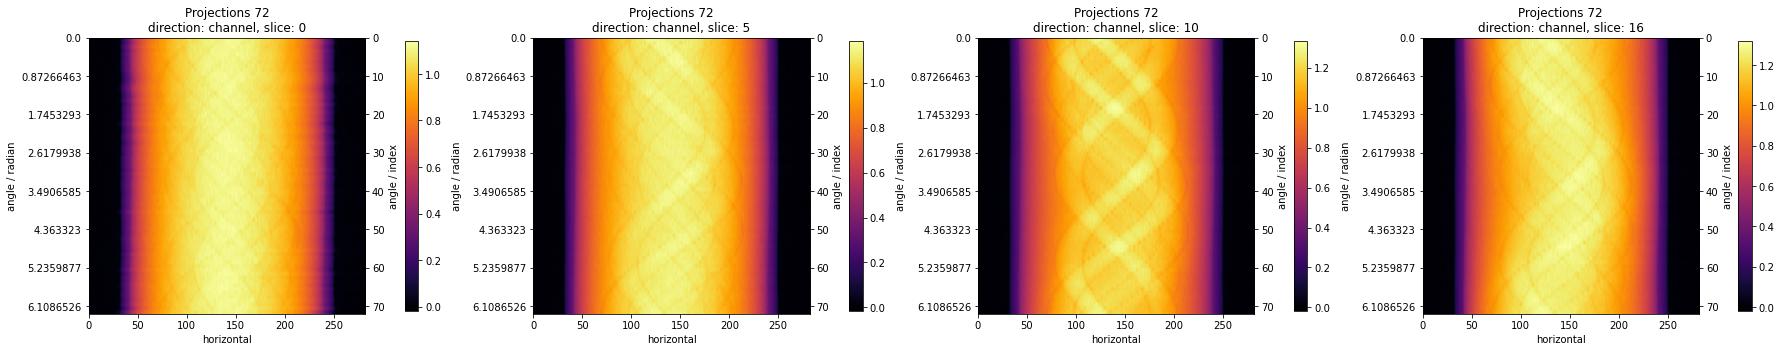

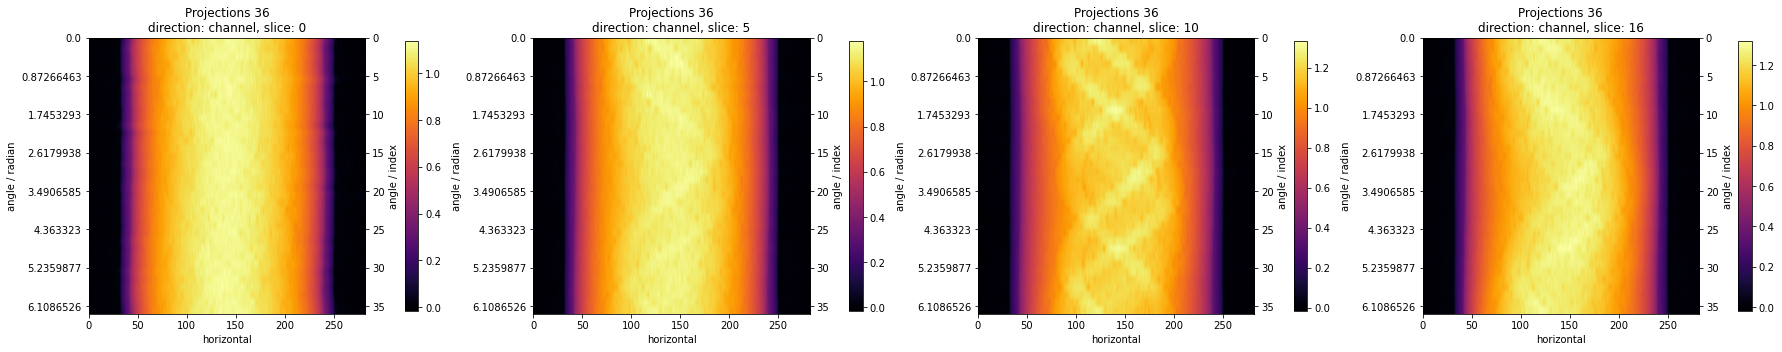

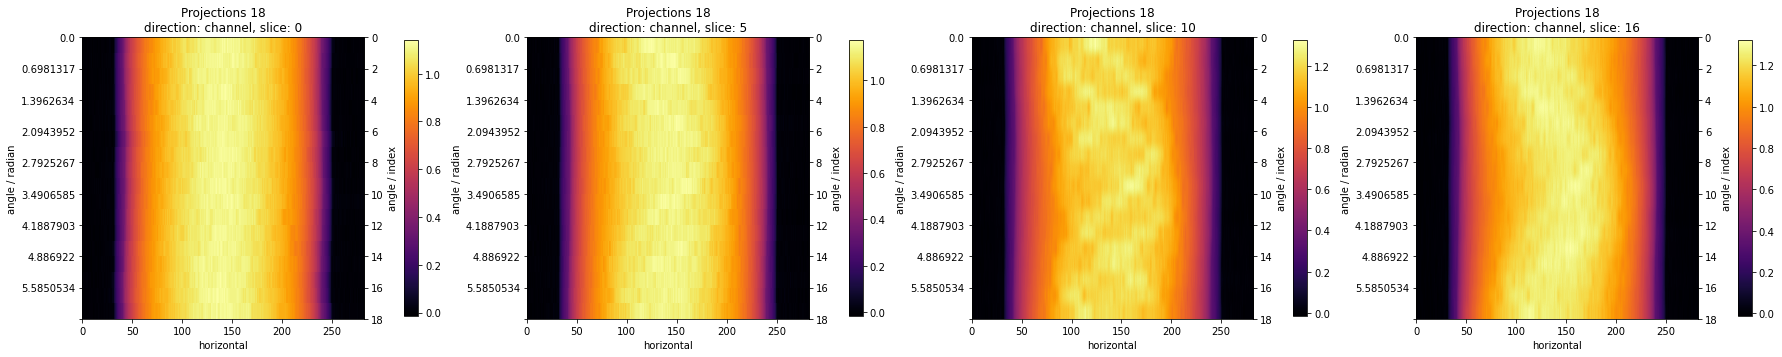

In [8]:
# Create and save Sparse Data with different angular sampling: 18, 36, 72, 360 projections
for step in [1, 5, 10, 20]:
    
    name_proj = "data_{}".format(int(360/step))
    new_data = Slicer(roi={'angle':(0,360,step)})(data)
    ag = new_data.geometry
    
    show2D(new_data, slice_list = [0,5,10,16], num_cols=4, origin="upper",
                       cmap="inferno", title="Projections {}".format(int(360/step)), size=(25, 20))    
    
    writer = NEXUSDataWriter(file_name = "SparseData/"+name_proj+".nxs",
                         data = new_data)
    writer.write()  
    

For the rest of the notebook, we use the sparse acquisition data `data_36`, i.e., only **36 projections** and perform the following:

- FBP reconstruction per time frame.
- Spatiotemporal TV reconstruction.
- Directional Total variation.

For the other cases, you can change the value of the `num_proj` below. Available data are: `data_18`, `data_36`, `data_72` and `data_360`.

<a id='num_proj'></a>

In [9]:
num_proj = 36
reader = NEXUSDataReader(file_name = "SparseData/data_{}.nxs".format(num_proj) )
data = reader.load_data()  
ag = data.geometry

## Channelwise FBP

For the **channelwise** FBP reconstruction, we perform the following steps

- Allocate a space using the full image geometry (2D+channels) `ig` geometry. 
- Extract the 2D acquisition and image geometries, using `ag.subset(channel=0)` and `ig.subset(channel=0)`.
- Run FBP reconstruction using the 2D sinogram data for every time frame.
- Fill the 2D FBP reconstruction with respect to the `channel=i` using the `fill` method.

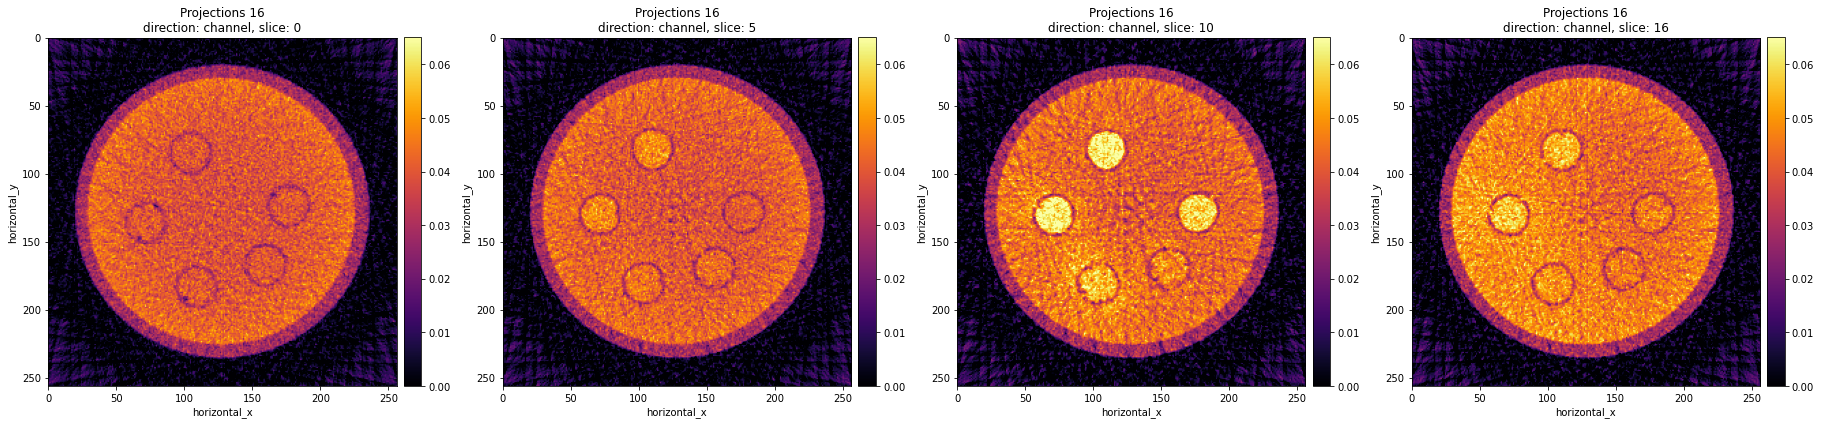

In [10]:
fbp_recon = ig.allocate()

ag2D = ag.subset(channel=0)
ig2D = ig.subset(channel=0)

for i in range(ig.channels):
    
    tmp = FBP(ig2D, ag2D)(data.subset(channel=i))
    fbp_recon.fill(tmp, channel=i)
    print("Finish FBP reconstruction for time frame {}".format(i), end='\r')
        
show2D(fbp_recon, slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title="Projections {}".format(i), size=(25, 20))
    
name_fbp = "FBP_projections_{}".format(num_proj)
writer = NEXUSDataWriter(file_name = "FBP_reconstructions/"+name_fbp+".nxs",
                     data = fbp_recon)
writer.write()      

## Exercise 2: Total Variation reconstruction

For the TV reconstruction, we use the **Explicit formulation** of the PDHG algorithm. See the [PDHG notebook](../week2/03_PDHG.ipynb) for more information.

- Define the `ProjectionOperator` and the `GradientOperator` using `correlation=SpaceChannels`.


```python    

        A = ProjectionOperator(ig, ag, 'gpu')        
        Grad = GradientOperator(ig, correlation = "SpaceChannels") 
    
```


- Use the `BlockOperator` to define the operator $K$. 

    

```python    

        K = BlockOperator(A, Grad)        
            
```


- Use the `BlockFunction` to define the function $\mathcal{F}$ that contains the fidelity term `L2NormSquared(b=data)` and the regularisation term `alpha_tv * MixedL21Norm()`, with `alpha_tv = 0.00063`. Finally, use the `IndicatorBox(lower=0.0)` to enforce a non-negativity constraint for the function $\mathcal{G}$.


```python    

        F = BlockFunction(0.5*L2NormSquared(b=data), alpha_tv * MixedL21Norm()) 
        G = IndicatorBox(lower=0)
            
```


In [11]:
A = ...        
Grad = ...

K = BlockOperator(A, Grad)

alpha_tv = 0.00054
F = BlockFunction(..., alpha_tv * ...)  
G = IndicatorBox(lower=0)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

pdhg_tv = PDHG(f = ..., g = ..., operator=..., max_iteration = 500,
            update_objective_interval = 100)    
pdhg_tv.run(verbose=1)

Initialised GradientOperator with C backend running with  2  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.20460e+04


/opt/SIRF-SuperBuild/INSTALL/python/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.151          2.00283e+01
      200        500         0.150          1.03788e+01
      300        500         0.150          8.91166e+00
      400        500         0.150          8.33918e+00
      500        500         0.150          8.04605e+00
-------------------------------------------------------
      500        500         0.150          8.04605e+00
Stop criterion has been reached.



## Exercise 2: Solution

In [ ]:
A = ProjectionOperator(ig, ag, 'gpu')        
Grad = GradientOperator(ig, correlation = "SpaceChannels") 

K = BlockOperator(A, Grad)

alpha_tv = 0.00054
F = BlockFunction(0.5*L2NormSquared(b=data), alpha_tv * MixedL21Norm())  
G = IndicatorBox(lower=0)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

pdhg_tv = PDHG(f = F, g = G, operator=K, max_iteration = 500,
            update_objective_interval = 100)    
pdhg_tv.run(verbose=1)

Initialised GradientOperator with C backend running with  2  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.20460e+04


/opt/SIRF-SuperBuild/INSTALL/python/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


## Show TV reconstruction for 4 different time frames

In [ ]:
titles_sinos = ["Time-frame {}".format(i) for i in [0,5,10,16]]

show2D(pdhg_tv.solution, slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title=titles_sinos, size=(25, 20))
    
name_tv = "TV_reconstruction_projections_{}".format(num_proj)
writer = NEXUSDataWriter(file_name = "TV_reconstructions/"+name_tv+".nxs",
                     data = pdhg_tv.solution)
writer.write()    

## Directional Total Variation

For our final reconstruction, we use a **structure-based prior**, namely the directional Total Variation (dTV) introduced in [Ehrhardt MJ, Arridge SR](https://doi.org/10.1109/tip.2013.2277775).

In comparison with the Total variation regulariser, 
$$
\mathrm{TV}(u) = \|\nabla u\|_{2,1} = \sum |\nabla u\|_{2},
$$

in the Direction Total variation, a weight in front of the gradient is used based on a **reference image**. This acts as prior information from which edge structures are propagated into the reconstruction process. For example, an image from another modality, e.g., MRI, , can be used in the PET reconstruction, see [Ehrhardt2016](https://ieeexplore.ieee.org/document/7452643/), [Ehrhardt2016MRI](https://epubs.siam.org/doi/10.1137/15M1047325). Another popular setup, is to use either both modalities or even channels in a joint reconstruction problem simultaneously, improving significantly the quality of the image, see for instance [Knoll et al](https://ieeexplore.ieee.org/document/7466848), [Kazantsev_2018](https://doi.org/10.1088/1361-6420/aaba86).

**Definition:** The dTV regulariser of the image $u$ given the reference image $v$ is defined as 

<a id='dynamic_dTV'></a>
$$\begin{equation}
d\mathrm{TV}(u,v)  := \|D_{v}\nabla u\|_{2,1} = \sum_{i,j=1}^{M,N} \big(|D_{v}\nabla u|_{2}\big)_{i,j},
\label{dTV_definition}
\end{equation}
$$

where the weight $D_{v}$ depends on the normalised gradient $\xi_{v}$ of the reference image $v$, 

$$\begin{equation}
D_{v} = \mathbb{I}_{2\times2} - \xi_{v}\xi_{v}^T, \quad \xi_{v} = \frac{\nabla v}{\sqrt{\eta^{2} + |\nabla v|_{2}^{2}}}, \quad \eta>0.
\label{weight_D}
\end{equation}
$$

In this dynamic sparse CT framework, we apply the dTV regulariser for each time frame $t$ which results to the following minimisation problem:

$$
\begin{equation}
u^{*}_{t} = \underset{u}{\operatorname{argmin}}  \, \frac{1}{2}\| A_\text{sc} u_{t}  - b_{t} \|^{2} + \alpha \, d\mathrm{TV}(u_{t}, v_{t})\quad \mbox{(Dynamic dTV)}, \label{dynamic_dtv_problem}
\end{equation}
$$

where $A_\text{sc}$, $b_{t}$, $u^{*}_{t}$, denote the single channel `ProjectionOperator`, the sinogram data and the reconstructed image for the time frame $t$ respectively.



## Reference images

In terms of the reference images $(v_{t})_{t=0}^{16}$, we are going to use the FBP reconstructions of the additional tomographic data. There are two datasets in `GelPhantom_extra_frames.mat` with dense sampled measurements from the first and last (18th) time steps:

- Pre-scan data with 720 projections
- Post-scan data with 1600 projections

We first read the matlab files and create the following acquisition data:

- data_pre_scan
- data_post_scan

In [ ]:
# Read matlab files for the extra frames
path = os.path.abspath("/mnt/materials/SIRF/Fully3D/CIL/GelPhantom")
data_mat_extra = "GelPhantom_extra_frames"

pre_scan_info = read_extra_frames(path, data_mat_extra, "GelPhantomFrame1_b4")
post_scan_info = read_extra_frames(path, data_mat_extra, "GelPhantomFrame18_b4")

# Acquisition geometry for the 1st frame: 720 projections
ag2D_pre_scan = AcquisitionGeometry.create_Cone2D(source_position = [0,   pre_scan_info['distanceSourceOrigin']],
                                       detector_position = [0, -pre_scan_info['distanceOriginDetector']])\
                                    .set_panel(num_pixels = pre_scan_info['numDetectors'], pixel_size = 2*pre_scan_info['pixelSize'])\
                                    .set_angles(pre_scan_info['angles'])\
                                    .set_labels(['angle', 'horizontal'])

# Acquisition geometry for the 18th frame: 1600 projections
ag2D_post_scan = AcquisitionGeometry.create_Cone2D(source_position = [0,   post_scan_info['distanceSourceOrigin']],
                                       detector_position = [0, -post_scan_info['distanceOriginDetector']])\
                                    .set_panel(num_pixels = post_scan_info['numDetectors'], pixel_size = 2*post_scan_info['pixelSize'])\
                                    .set_angles(post_scan_info['angles'])\
                                    .set_labels(['angle', 'horizontal'])

data_pre_scan = ag2D_pre_scan.allocate()
data_pre_scan.fill(pre_scan_info['sinograms'])

data_post_scan = ag2D_post_scan.allocate()
data_post_scan.fill(post_scan_info['sinograms'])


show2D([data_pre_scan,data_post_scan], title=["Pre-scan 720 projections", "Post-scan 1600 projections"], cmap="inferno", size=(10,10))

## FBP reconstruction (Reference images)

For the FBP reconstruction of the pre/post scan we use the 2D image geometry, `ig2D` and the corresponding acquisition geometries `ag2D_pre_scan` and `ag2D_post_scan`.

## Exercise 3: Perform FBP to obtain the reference images

In [ ]:
fbp_recon_pre_scan = FBP(..., ag2D_pre_scan)(...)
fbp_recon_post_scan = FBP(ig2D, ...)(...)

## Exercise 3: Solution

In [ ]:
fbp_recon_pre_scan = FBP(ig2D, ag2D_pre_scan)(data_pre_scan)
fbp_recon_post_scan = FBP(ig2D, ag2D_post_scan)(data_post_scan)

## Show and save the reference images

In [ ]:
show2D([fbp_recon_pre_scan,fbp_recon_post_scan], 
       title=["FBP: Pre-scan", "FBP: Post-scan"], cmap="inferno", origin="upper", fix_range=(0,0.065))

name_fbp_pre_scan = "FBP_pre_scan"
writer = NEXUSDataWriter(file_name = "FBP_reconstructions/"+name_fbp_pre_scan+".nxs",
                     data = fbp_recon_pre_scan)
writer.write() 

name_fbp_post_scan = "FBP_post_scan"
writer = NEXUSDataWriter(file_name = "FBP_reconstructions/"+name_fbp_post_scan+".nxs",
                     data = fbp_recon_post_scan)
writer.write() 

## Edge information from the normalised gradient $\,\xi_{v}$

In the following we compute the normalised gradient $\,\xi_{v}$ for the two reference images using different $\eta$ values:

$$\xi_{v} = \frac{\nabla v}{\sqrt{\eta^{2} + |\nabla v|_{2}^{2}}}, \quad \eta>0$$

In [ ]:
def xi_vector_field(image, eta):
    
    ig = image.geometry
    ig.voxel_size_x = 1.
    ig.voxel_size_y = 1.
    G = GradientOperator(ig)
    numerator = G.direct(image)
    denominator = np.sqrt(eta**2 + numerator.get_item(0)**2 + numerator.get_item(1)**2)
    xi = numerator/denominator
                
    return (xi.get_item(0)**2 + xi.get_item(1)**2).sqrt()

etas = [0.001, 0.005]

xi_post_scan = []
xi_pre_scan = []

for i in etas:
    
    xi_post_scan.append(xi_vector_field(fbp_recon_post_scan, i))
    xi_pre_scan.append(xi_vector_field(fbp_recon_pre_scan, i))

## Edge information from the pre-scan and post-scan reference images

In [ ]:
title_etas = ["$\eta$ = {}".format(eta) for eta in etas]
show2D(xi_pre_scan, cmap="inferno", title=title_etas, origin="upper", num_cols=2, size=(10,10))
show2D(xi_post_scan, cmap="inferno", title=title_etas, origin="upper", num_cols=2,size=(10,10))

## Directional Total variation reconsturction 

In total we have 17 time frames, and we need 17 reference images.  Due to a slight movement of the sample at the beginning of the experiment, we apply the pre-scan reference image for the first time frame and use the post-scan reference image for the remaining time frames. 

One could apply other configurations for the reference image in the intermediate time frames. For example, in order to reconstruct the $(t+1)$th time frame, one could use the $t$th time frame reconstruction as reference. A more sophisticated reference selection approach is applied in hyperspectral computed tomography in [Kazantsev_2018](https://iopscience.iop.org/article/10.1088/1361-6420/aaba86).

In order to solve the [Dynamic dTV](#dynamic_dTV) problem, we the implicit formulation of the PDHG algorithm, where the **FGP_dTV** algorithm is applied for the inner proximal problem.

- We first define the single slice `ProjectionOperator` using the 2D image and acquisition geometries and compute the `sigma` and `tau` stepsizes.


```python    

    K = ProjectionOperator(ig2D, ag2D, 'gpu') 

    normK = K.norm()
    sigma = 1./normK
    tau = 1./normK   
    
```


- We allocate space for the dTV reconstruction, i.e., `dtv_recon` using the full image geometry `ig`.



- Use the following values: `max_iteration=100`, `alpha_dtv = 0.0072`, `eta=0.005`.




- Loop over all the time frames (`tf`) and update :



    - the fidelity term `0.5 * L2NormSquared(b=data.subset(channel=tf)` for the function $\mathcal{F}$,        
        
    - the regularisation term using the `FGP_dTV` function class from the `CCPi-Regularisation Toolkit` for the  function $\mathcal{G}$. For `tf=0` the pre-scan reference is used and for `tf>0` the post-scan reference is used.    
    
    
    

In [ ]:
# Setup and run PDHG with 
K = ProjectionOperator(ig2D, ag2D, 'gpu') 

normK = K.norm()
sigma = 1./normK
tau = 1./normK  

dtv_recon = ig.allocate()

max_iterations = 100
alpha_dtv = 0.0072
eta = 0.005

for tf in range(ig.channels):
    
    F = 0.5 * L2NormSquared(b=data.subset(channel=tf))
    
    if tf==0:        
        G = alpha_dtv * FGP_dTV(reference = fbp_recon_pre_scan, eta=eta, device='gpu')  
    else:        
        G = alpha_dtv * FGP_dTV(reference = fbp_recon_post_scan, eta=eta, device='gpu')
        
   
    pdhg_dtv = PDHG(f=F, g=G, operator = K, tau = tau, sigma = sigma,
            max_iteration = max_iterations, update_objective_interval=100)
    pdhg_dtv.run(verbose = 0)
    
    clear_output(wait=True) 
    
    print("Finish dTV regularisation for the frame {} with {} projections\n".format(tf,num_proj), end='\r')
    
    dtv_recon.fill(pdhg_dtv.solution, channel=tf)    

In [ ]:
show2D(dtv_recon, slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title=titles_sinos, size=(25, 20))

## FBP vs TV vs dTV reconstructions vs FBP (360 projections).

For our final comparison, we reconstruct the full dataset, i.e., 360 projections and compare it with the FBP, TV and dTV reconstruction with 36 projection.

In [ ]:
# Load data with 360 projections
reader = NEXUSDataReader(file_name = "SparseData/data_360.nxs")
data_360 = reader.load_data()
ag2D = data_360.geometry.subset(channel=0)

# Perform channelwise FBP reconstruction
fbp_recon_360 = ig.allocate()
for i in range(ig.channels):    
    tmp = FBP(ig2D, ag2D)(data_360.subset(channel=i))
    fbp_recon_360.fill(tmp, channel=i)     

## Show FBP, TV, dTV with 36 projections and FBP with 360 projections. 

In [ ]:
show2D(fbp_recon,slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title=titles_sinos, size=(25, 20))

show2D(pdhg_tv.solution,slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title=titles_sinos, size=(25, 20))

show2D(dtv_recon,slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title=titles_sinos, size=(25, 20))

show2D(fbp_recon_360,slice_list = [0,5,10,16], num_cols=4, origin="upper",fix_range=(0,0.065),
                   cmap="inferno", title=titles_sinos, size=(25, 20))

<h1><center>Conclusions</center></h1>

In this notebook, we presented three different reconstruction methods for undersampled dynamic tomographic data. The **channelwise FBP** and the **Spatiotemporal TV** and **Directional TV** regularisation. We focused on the reconstruction of the dataset with 36 projections out of 360 projections. 

As an additional **Exercise**, you can try other configurations, namely the datasets `data_18` and `data_72` by changing the [number of projections](#num_proj). The optimal regularisation parameters for spatiotemporal TV and dTV are reported in Table 1 in [Papoutsellis et al](https://arxiv.org/pdf/2102.06126.pdf#page=7).

So far, we presented how to reconstruct two different multichannel datasets:

* **[Color](01_Color_Processing.ipynb)**: 3 channels that encodes information for the red, green and blue colors.
* **Dynamic**: 17 channels that encode temporal information from our acquisition tomographic data.

In the next notebook, we focus on a 4D hypespectral dataset where the channel dimension contains spectral energy information acquired from an energy-sensitive X-ray detector. 